In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing

from scipy.stats import skew
import scipy.stats as st
plt.style.use('seaborn')
%matplotlib inline

## Import Data

In [2]:
#import train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_all = pd.concat([train.drop(columns=['SalePrice', 'Id']), test.drop(columns='Id')])
original_col = train.drop(columns=['SalePrice', 'Id']).columns

In [3]:
# print(original_col)

In [4]:
print(f'Concated shape: {df_all.shape}')

Concated shape: (2919, 79)


## Treat Missing Value

<AxesSubplot:>

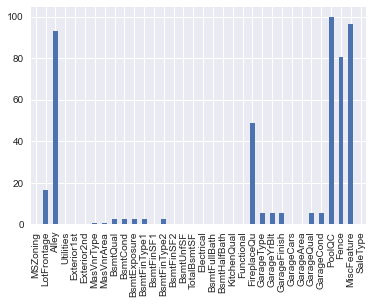

In [5]:
# Missing Value
null_sum = df_all.isnull().sum()
(null_sum[null_sum > 0]/(df_all.shape[0])*100).plot.bar()

In [6]:
# Removing missing value more than 20%
null_perc = (null_sum[null_sum > 0]/(df_all.shape[0])*100)
print(null_perc[null_perc>20].index)
df_all = df_all.drop(columns=null_perc[null_perc>20].index)

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


In [7]:
null_columns = list(null_perc[null_perc<=20].index)
print(null_columns)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [8]:
for c in null_columns:
    if df_all[c].dtype == 'object':
        df_all[c] = df_all[[c]].replace(np.NAN, df_all[c].mode()[0])
    else:
        df_all[c] = df_all[c].replace(np.NAN, df_all[c].mean())
        
print(df_all.isnull().sum()[df_all.isnull().sum() > 0])

Series([], dtype: int64)


## Simplify Qualitative Features 

In [9]:
sim_qual = ['BsmtFinType1','BsmtFinType2','ExterQual','ExterCond','BsmtQual','BsmtCond',
            'HeatingQC','KitchenQual','GarageCond','GarageQual','GarageFinish', 'BsmtExposure','PavedDrive']

In [10]:
count = 0
for c in sim_qual:
    if (count<2):
        df_all[c] = df_all[c].replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
    if (count>=2 and count<10):
        df_all[c] = df_all[c].replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
    if (count == 10):
        df_all[c] = df_all[c].replace(dict(Fin=3, RFn=2, Unf=1, NA=0))
    if (count == 11):
        df_all[c] = df_all[c].replace(dict(Gd=4, Av=3, Mn=2, No=1, NA=0))
    if (count == 12):
        df_all[c] = df_all[c].replace(dict(Y=2, P=1, N=0))
    print(f'count: {count} ---- Simplified feature : {c}')
    count+=1
    

count: 0 ---- Simplified feature : BsmtFinType1
count: 1 ---- Simplified feature : BsmtFinType2
count: 2 ---- Simplified feature : ExterQual
count: 3 ---- Simplified feature : ExterCond
count: 4 ---- Simplified feature : BsmtQual
count: 5 ---- Simplified feature : BsmtCond
count: 6 ---- Simplified feature : HeatingQC
count: 7 ---- Simplified feature : KitchenQual
count: 8 ---- Simplified feature : GarageCond
count: 9 ---- Simplified feature : GarageQual
count: 10 ---- Simplified feature : GarageFinish
count: 11 ---- Simplified feature : BsmtExposure
count: 12 ---- Simplified feature : PavedDrive


In [11]:
#Quantitative and Qualitative features
quantitative = [f for f in df_all.columns if df_all.dtypes[f] != 'object']
qualitative = [f for f in df_all.columns if df_all.dtypes[f] == 'object']

In [12]:
print(f'Quantitative features : {quantitative}')
print(f'Qualitative features : {qualitative}')

Quantitative features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Qualitative features : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', '

## Binning Year Features 

In [13]:
#   Feature Engineering : 1. Creating new features
#     Using binned technique for "YearBuilt", "YearRemodAdd" & "YrSold"
col = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']
for c in col:
    df_all[c] = pd.qcut(df_all[c], 10, duplicates='drop')

In [14]:
#     Encode categorical features to numeric feature
for c in col:
    df_all[c] = preprocessing.LabelEncoder().fit_transform(df_all[c].values)

In [15]:
#     Check values
df_all[col] = df_all[col]
df_all[col].head()

,YearBuilt,YearRemodAdd,YrSold,GarageYrBlt
0,7,6,1,7
1,5,2,0,4
2,7,5,1,7
3,0,1,0,6
4,7,5,1,7


## Creating Combination Features 

In [16]:
#    New Features

#Total Lot Area
df_all['TotalLot'] = df_all['LotFrontage'] + df_all['LotArea']

#Overall House Quality&Condition
# df_all['Overall'] = df_all['OverallCond'] + df_all['OverallQual']

#Total number of basement bathroom
df_all['BsmtBath'] = df_all['BsmtFullBath'] + df_all['BsmtHalfBath']

#Total number of bathroom above grade
df_all['Bath'] = df_all['FullBath'] + df_all['HalfBath']

#total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + 0.5*df_all['HalfBath'] 
                        + df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath'])

# #Total Finished Square Feet Above Grade
# df_all['FloorFinSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF']

#Ratio of Low Quality Squared Feet to Total Finished Square Feet Above Grade
# df_all['R_LowQual_FloorFinSF'] = df_all['LowQualFinSF'] / df_all['FloorFinSF']

#Ratio of Basement Unfinished Squared Feet to Total Basement Squared feet
# df_all['R_BsmtUnfSF_TotalBsmtSF'] = df_all['BsmtUnfSF'] / df_all['TotalBsmtSF']

#Total Basement Fin SF
df_all['TotalBsmtFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2']

#Total Finished Squared feet
df_all['TotalFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Total SF for house (incl. basement)
df_all["AllSF"] = df_all["GrLivArea"] + df_all["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
df_all["AllFlrsSF"] = df_all["1stFlrSF"] + df_all["2ndFlrSF"]

#Total Basement Unfinish SF and Low Quality Finished SF
df_all['Total_BsmtUnfSf_LowQualFinSF'] = df_all['BsmtUnfSF'] + df_all['LowQualFinSF']

#Total Porch SF
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] 
                            + df_all['ScreenPorch'] + df_all['WoodDeckSF'])
df_all = df_all.drop(columns=['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF'])

#Garage
df_all['GarageArea'] = df_all['GarageArea'].apply(lambda x: 1 if x>0 else 0)

#Pool
df_all['PoolArea'] = df_all['PoolArea'].apply(lambda x: 1 if x>0 else 0)


In [17]:
#Ratio of Low Quality Squared Feet to Total Finished Square Feet Above Grade
# df_all['R_LowQual_FloorFinSF'] = df_all['LowQualFinSF'] / df_all['FloorFinSF']

#Ratio of Basement Unfinished Squared Feet to Total Basement Squared feet
# df_all['R_BsmtUnfSF_TotalBsmtSF'] = df_all['BsmtUnfSF'] / df_all['TotalBsmtSF']

#Cars per Garage Area
# df_all['CarsPerGarageArea'] = df_all['GarageCars'] / df_all['GarageArea']

#Ratio of Total Finished Square Feet Above Grade to 
# df_all['R_FloorFinSF_'] = df_all['FloorFinSF'] / df_all['BedroomAbvGr']

In [18]:
#Overall House Quality and Condition Score
df_all['OverallScore'] = df_all['OverallCond'] * df_all['OverallQual']

#Overall Kitchen Score 
df_all['KitchenScore'] = df_all['KitchenAbvGr'] * df_all['KitchenQual']

#Overall Exter Score
df_all['ExterScore'] = df_all['ExterCond'] * df_all['ExterQual']

#Basement Finished Type Score
df_all['BsmtFinTypeScore'] = (df_all['BsmtFinType1'] + df_all['BsmtFinType2']) * df_all['BsmtExposure']

#Basement Score
df_all['BsmtScore'] = df_all['BsmtQual'] * df_all['BsmtCond'] 

#Overall Garage Score
df_all['GarageScore'] = df_all['GarageQual'] * df_all['GarageCond']

In [19]:
# #Basement score and SF
# df_all['BsmtScore_andFinSF'] = df_all['BsmtScore']+df_all['TotalBsmtFinSF']

# #Overall Score per GrLivArea
# df_all['OverallScore_andGrLivArea'] =  df_all['GrLivArea'] * df_all['OverallScore']

# #OverallScore and BsmtScore
# df_all['OverallScore_andBsmtScore'] = df_all['OverallScore'] + df_all['BsmtScore']

# #OverallScore and KitchenScore 
# df_all['OverallScore_andKitchenScore'] = df_all['OverallScore'] + df_all['KitchenScore']

# #OverallScore and ExterScore
# df_all['OverallScore_andExterScore'] = df_all['OverallScore'] + df_all['ExterScore']

# #OverallScore and GarageScore
# df_all['OverallScore_andGarageScore'] = df_all['OverallScore'] + df_all['GarageScore']

In [20]:
#Scoring multiply
scoring_multiply = ['OverallScore', 'KitchenScore', 'ExterScore', 'BsmtFinTypeScore', 'BsmtScore', 'GarageScore']
for c in range(0,5):
    for updated in range(1,len(scoring_multiply)):
        name = scoring_multiply[0]+'_and'+scoring_multiply[updated]
        value = df_all[scoring_multiply[0]] + df_all[scoring_multiply[updated]]
        df_all[name] = value
        print('Feature created: ',name)
    scoring_multiply.remove(scoring_multiply[0])

Feature created:  OverallScore_andKitchenScore
Feature created:  OverallScore_andExterScore
Feature created:  OverallScore_andBsmtFinTypeScore
Feature created:  OverallScore_andBsmtScore
Feature created:  OverallScore_andGarageScore
Feature created:  KitchenScore_andExterScore
Feature created:  KitchenScore_andBsmtFinTypeScore
Feature created:  KitchenScore_andBsmtScore
Feature created:  KitchenScore_andGarageScore
Feature created:  ExterScore_andBsmtFinTypeScore
Feature created:  ExterScore_andBsmtScore
Feature created:  ExterScore_andGarageScore
Feature created:  BsmtFinTypeScore_andBsmtScore
Feature created:  BsmtFinTypeScore_andGarageScore
Feature created:  BsmtScore_andGarageScore


In [21]:
col.extend(['GarageArea', 'PoolArea', 'MoSold'])
print(col)

['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt', 'GarageArea', 'PoolArea', 'MoSold']


## Creating New Polynomial Features 

In [22]:
quantitative = [f for f in df_all.columns if df_all.dtypes[f] != 'object']

###SUSPECT####
for c in col:
    quantitative.remove(c)
    
train = pd.concat([train[['Id','SalePrice']], df_all[:1460]], axis=1)


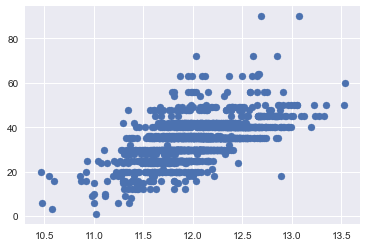

In [23]:
plt.scatter(x=np.log1p(train.SalePrice), y=train.OverallScore)

In [24]:
quantitative.append('SalePrice')
corr = train[quantitative].corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
corr.SalePrice.head(16)

SalePrice                           1.000000
OverallQual                         0.790982
AllSF                               0.778959
AllFlrsSF                           0.716883
GrLivArea                           0.708624
TotalFinSF                          0.708047
ExterScore_andBsmtScore             0.684020
ExterQual                           0.682639
KitchenQual                         0.659600
BsmtQual                            0.650138
OverallScore_andBsmtScore           0.649221
KitchenScore_andBsmtScore           0.647773
GarageCars                          0.640409
TotalBath                           0.631731
OverallScore_andBsmtFinTypeScore    0.617242
TotalBsmtSF                         0.613581
Name: SalePrice, dtype: float64

In [25]:
# Create Polynomials Features
for c in corr.SalePrice[1:15].index:
    df_all[c + '_s2'] = df_all[c] ** 2
    df_all[c + '_s3'] = df_all[c] ** 3
    df_all[c + '_sqrt'] = np.sqrt(df_all[c])
#     df_all[c + '_cbrt'] = np.cbrt(df_all[c])

## Skew

In [26]:
#   Log Transform Low and High Skewness of Features
quantitative.remove('SalePrice')
skewness = (df_all[quantitative]).apply(lambda x: skew(x))

skewness = skewness[abs(skewness) > 0.5]
print(skewness.sort_values(ascending=False))
df_all[skewness.index] = np.log1p(df_all[skewness.index])

MiscVal                             21.947195
LotArea                             12.822431
TotalLot                            12.793661
LowQualFinSF                        12.088761
KitchenAbvGr                         4.302254
BsmtFinSF2                           4.146034
BsmtHalfBath                         3.931343
BsmtFinType2                         3.371116
MasVnrArea                           2.611549
TotalFinSF                           1.835969
LotFrontage                          1.645574
AllSF                                1.515497
1stFlrSF                             1.469604
BsmtFinSF1                           1.425233
BsmtFinTypeScore                     1.408689
KitchenScore_andBsmtFinTypeScore     1.396594
TotalPorchSF                         1.376649
MSSubClass                           1.375457
ExterCond                            1.315913
BsmtFinTypeScore_andGarageScore      1.309428
ExterScore_andBsmtFinTypeScore       1.302848
GrLivArea                         

## Fillna(0) 

In [27]:
n = df_all.isnull().sum()
n[n> 0]

Series([], dtype: int64)

In [28]:
df_all = df_all.fillna(0)

In [29]:
n = df_all.isnull().sum()
n[n> 0]

Series([], dtype: int64)

## Dummy Features 

In [30]:
# qualitative.extend(col)
print(qualitative)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'SaleType', 'SaleCondition']


In [31]:
qualitative = [f for f in df_all.columns if df_all.dtypes[f] == 'object']
qualitative.extend(col)
print(qualitative)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'SaleType', 'SaleCondition', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt', 'GarageArea', 'PoolArea', 'MoSold']


In [32]:
# Dummy Features
print(f'Before dummy feature: {df_all.shape}')
df_all = pd.get_dummies(df_all, columns=qualitative)
print(f'Before dummy feature: {df_all.shape}')
# print("Remaining NAs for categorical features in train : " + str(df.isnull().values.sum()))

Before dummy feature: (2919, 142)
Before dummy feature: (2919, 335)


## Outliers 

In [33]:
# Check SalePrice Skewness
train = pd.concat([train[['Id','SalePrice']], df_all[:1460]],axis=1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

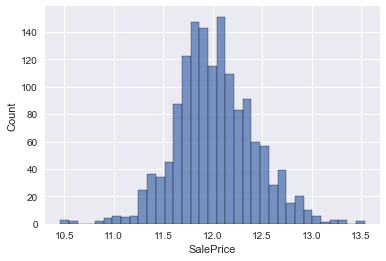

In [34]:
train['SalePrice'] = np.log1p(train.SalePrice)
y = train['SalePrice']
sns.histplot(x=y)

<AxesSubplot:xlabel='SalePrice', ylabel='GrLivArea'>

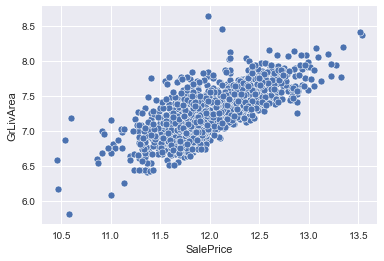

In [35]:
# Remove Outliers
sns.scatterplot(data=train, x='SalePrice', y='GrLivArea')

In [36]:
train = train[train.SalePrice<13.5]
train = train[train.SalePrice>10.75]
train = train[train.GrLivArea<8.25]

<AxesSubplot:xlabel='SalePrice', ylabel='GrLivArea'>

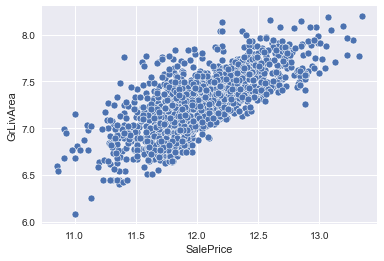

In [37]:
sns.scatterplot(data=train, x='SalePrice', y='GrLivArea')

In [38]:
train.to_csv('train_v2.csv',index=False)
test = df_all[1460:]
test.to_csv('test_v2.csv', index=False)

In [39]:
y = train.SalePrice
train = train.drop(columns=['Id','SalePrice'])
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,4.110874,4.189655,9.042040,7,1.791759,5.283204,1.609438,1.386294,4,3,...,0,0,0,0,0,0,0,0,0,0
1,3.044522,4.394449,9.169623,6,2.197225,0.000000,1.386294,1.386294,4,3,...,0,0,1,0,0,0,0,0,0,0
2,4.110874,4.234107,9.328212,7,1.791759,5.093750,1.609438,1.386294,4,3,...,0,0,0,0,0,0,1,0,0,0
3,4.262680,4.110874,9.164401,7,1.791759,0.000000,1.386294,1.386294,3,4,...,0,0,0,0,0,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,1.791759,5.860786,1.609438,1.386294,4,3,...,0,0,0,0,0,0,0,0,0,1


# ElasticNet 

In [ ]:
print(f'Train: {train.shape}')
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.30, random_state=0)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

In [ ]:
# Standardize numerical features
stdSc = StandardScaler()
X_train = pd.DataFrame(stdSc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(stdSc.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [ ]:
# Modelling
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 100000, cv = 10)

In [ ]:
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 100000, cv = 10)

In [ ]:
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 100000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

In [ ]:
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

# 6. Test set prediction 

In [ ]:
df_all.shape

In [ ]:
test = df_all[1460:]
test.head()

In [ ]:
test = pd.DataFrame(stdSc.transform(test), columns=test.columns, index=test.index)

In [ ]:
print(f'Test Shape: {test.shape}')

In [ ]:
test_pred = elasticNet.predict(test)
print(test_pred)

In [ ]:
test_pred = np.expm1(test_pred)
print(test_pred)

In [ ]:
submission = pd.concat([pd.read_csv('test.csv').Id, pd.DataFrame(test_pred, columns=['SalePrice'])], axis=1)

In [ ]:
submission.to_csv('Aug16_v11.csv',index=False)